# Stellar population fit by ppxf

## Import relevant modules

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from os.path import basename
from copy import copy

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

from scripts.ned_calculator import NedCalculator
from scripts.der_snr import DER_SNR
import os

## Create necessary functions

In [184]:
def bootstrap_residuals(model, resid, wild=True):
    """
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Resampling_residuals
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Wild_bootstrap

    Davidson & Flachaire (2008) eq.(12) gives the recommended form
    of the wild bootstrapping probability used here.

    https://doi.org/10.1016/j.jeconom.2008.08.003

    :param spec: model (e.g. best fitting spectrum)
    :param res: residuals (best_fit - observed)
    :param wild: use wild bootstrap to allow for variable errors
    :return: new model with bootstrapped residuals

    """
    if wild:    # Wild Bootstrapping: generates -resid or resid with prob=1/2
        eps = resid*(2*np.random.randint(2, size=resid.size) - 1)
    else:       # Standard Bootstrapping: random selection with repetition
        eps = np.random.choice(resid, size=resid.size)

    return model + eps

In [185]:
def read_fits_summary(fitsfile):
    
    hdu = fits.open(fitsfile)
    
    age_grid = hdu['age_grid'].data
    weights = hdu['pp_weights'].data.reshape(hdu['reg_dim'].data)
    
    name = hdu[0].header['name']
    z = hdu[0].header['z']
    hdu.close()
    del hdu
    
    wei1 = weights.sum(axis=1)
    wei1/=wei1.sum()
    
    wei1_rev = copy(wei1[::-1])
    
    ages = age_grid[:,0]
    ages1 = (ages[-1]-ages)[::-1]+(ages[1]-ages[0])
    
    agesplot = np.concatenate([np.array([0.]),ages1])
    weiplot = np.concatenate([np.array([0.]),np.cumsum(wei1_rev)])
    
    agesplot = np.concatenate([agesplot,np.array([agesplot[-1]+(agesplot[-1]-agesplot[-2])])])
    weiplot = np.concatenate([weiplot,np.array([weiplot[-1]])])
    
    nedcalc = NedCalculator(z)
    univ_age = nedcalc.zage_Gyr
    
    agesplot = [a if a<univ_age else univ_age for a in agesplot]
    
    return name,z,agesplot,weiplot,univ_age

In [186]:

def plot_sfh(ax,fitsfile,col_line,legend_on=False):
    
    name,z,agesplot,weiplot,univ_age = read_fits_summary(fitsfile)

    ax.set_title(name,fontsize=18,weight='bold')
    ax.set_xlim(0,13.5)
    ax.set_ylim(-0.05,1.05)
    ax.set_xlabel('Time since BB (Gyr)',fontsize=15)
    ax.set_ylabel('Cumulative mass %',fontsize=15)
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='in',labelsize=15)
    
    ax.axhline(0.75,color='gray',alpha=0.2)
    ax.text(12,0.76,'75%',style='italic',color='gray')
    ax.axhline(0.95,color='gray',alpha=0.2)
    ax.text(12,0.96,'95%',style='italic',color='gray')
    ax.axvline(3.,color='gray',alpha=0.2,linestyle='-.',linewidth=2.)
    ax.axvline(univ_age,color='gray',linestyle='-.',linewidth=2.)
    
    ax.plot(agesplot,weiplot,color=col_line,linewidth=3.)
    
    ax.text(univ_age-0.1,0.,'today',color='gray',style='italic',rotation=90,horizontalalignment='right')
    ax.text(2.9,0.,'z~2',style='italic',color='gray',rotation=90,horizontalalignment='right')
    ax.set_xticks([0.,2.,4.,6.,8.,10.,12.])
    
    if legend_on==True:
        ax.legend(frameon=False,bbox_to_anchor=(univ_age/ax.get_xlim()[1], -0.05),loc='lower right',prop={'size':12,'weight':'bold'},labelspacing=0.1,labelcolor='linecolor')
        
    return agesplot,weiplot

In [187]:
def line2p(p1,p2,x):
    
    x1,y1 = p1
    x2,y2 = p2
    
    m = (y2-y1)/(x2-x1)
    q = -(y2-y1)/(x2-x1)*x1+y1
    
    return m*x+q

def line2p_rev(p1,p2,y):
    
    x1,y1 = p1
    x2,y2 = p2
    
    return (y-y1)/(y2-y1)*(x2-x1)+x1 if y2!=y1 else x2
    
def get_values_from_sfh(univ_age,sfh_table,ycol):
    '''
    INPUTS:
        univ_age: the age of the universe at the redshift of the galaxy in Gyr
        sfh_table: the plotted sfh in the form of a pandas DataFrame. It needs to have a column named "time"
        ycol: is the name of the column of the sfh_table we want to use in order to retrieve the different values we want to compute
    
    OUTPUTS:
        y_z2: mass formed at redshift~2
        x_075: time to form 75% of the mass (t_75)
        x_090: time to form 90% of the mass (t_90)
        x_100: time to form 100% of the mass (t_fin)
        dor_90: Degree of Relicness using x_090
        dor_100: : Degree of Relicness using x_100
        
    '''
    
    tt = []
    tt90 = []
    tt100 = []
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.75:
        tt.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy = sfh_table.iloc[np.array(tt[-2:])[:,0]]
    
    xx = line2p_rev(yy[['time',ycol]].iloc[0].values,yy[['time',ycol]].iloc[1].values,0.75)
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.9 :
        tt90.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt90.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy90 = sfh_table.iloc[np.array(tt90[-2:])[:,0]]
    
    xx90 =  line2p_rev(yy90[['time',ycol]].iloc[0].values,yy90[['time',ycol]].iloc[1].values,0.9)
    
    ii=0
    while sfh_table.iloc[ii][ycol]<0.998 :
        tt100.append((ii,sfh_table.iloc[ii][ycol]))
        ii+=1
    tt100.append((ii,sfh_table.iloc[ii][ycol]))
    
    yy100 = sfh_table.iloc[np.array(tt100[-2:])[:,0]]
    
    xx100 =  line2p_rev(yy100[['time',ycol]].iloc[0].values,yy100[['time',ycol]].iloc[1].values,0.998)
    
    tt_rev = [(0,0)]
    
    for i in range(1,len(sfh_table['time'])):
        
        p1 = sfh_table['time'].iloc[i-1],sfh_table[ycol].iloc[i-1]
        p2 = sfh_table['time'].iloc[i],sfh_table[ycol].iloc[i]
        
        xs = np.arange(sfh_table['time'].iloc[i-1],sfh_table['time'].iloc[i]+0.1,0.1)
        ys = line2p(p1,p2,xs)

                
        for x,y in zip(xs,ys):
            tt_rev.append((round(x,2),y))


    tt_rev = np.array(tt_rev)

    # this is the mass formed at redshift ~2
    y_z2 = round(tt_rev[:,1][np.where(tt_rev[:,0]==2.90)[0]][0],5)
    
    # these are the times at 75%, 90%, and 100% formed mass
    x_075 = round(xx,5)
    x_090 = round(xx90,5)
    x_100 = round(xx100,5)
    
    dor_90 = (y_z2+0.5/x_075+(0.7+(univ_age-x_090)/univ_age))/3
    dor_100 = (y_z2+0.5/x_075+(0.7+(univ_age-x_100)/univ_age))/3
    
    
    
    return y_z2,x_075,x_090,x_100,dor_90,dor_100

## Load in the shortlist csv

In [188]:
# The catalogue with all the galaxies
df_in = pd.read_csv('../data/INSPIRE.csv')
df_in.head()

,ID_INSPIRE,RAJ2000,DECJ2000,zspec_XSH,Vdisp_XSH,err_Vdisp_XSH,AlphaFe
0,J1438-0127,219.521888,-1.458273,0.2861,218,1.9,0.4
1,J1412-0020,213.003828,-0.344070,0.2783,339,3.7,0.0
2,J0224-3143,36.090265,-31.724492,0.3839,283,1.0,0.3
3,J2356-3332,359.126125,-33.533475,0.3389,162,6.0,0.2
4,J0918+0122,139.644643,1.379478,0.3731,242,2.0,0.2


## Iterate over each row to fit the stellar population of each object

In [189]:
tie_balmer = True
limit_doublets = True

c = 299792.458  # speed of light in km/s

regul_err = 0.1 # Large regularization error

vel = 0   # eq.(8) of Cappellari (2017)

moments = [4, 2, 2]

gas_reddening = 0 if tie_balmer else None

logAges = []
metals = []
snrs = []
ids=[]

nrand = 9

col_line1 = 'black' # gdago: here you choose the color of the line        
col_line2 = 'green' # gdago: here you choose the color of the line

# Some lists to add into the catalogue later
mass_fracs = []
times_75 = []
times_90 = []
times_100 = []
dors_100 = []
univ_ages = []

mass_fracsu = []
times_75u = []
times_90u = []
times_100u = []
dors_100u = []

mass_fracsr = []
times_75r = []
times_90r = []
times_100r = []
dors_100r = []

#gal_list = ['J1438-0127', 'J2356-3332', 'J1420-0035', 'J0316-2953', 'J1412-0020'] # 'J1142+0012'
#df_in=df_in[df_in['ID_INSPIRE'].isin(gal_list)]
#print(df_in)

In [190]:
"""from astropy.io import fits

# Replace with your actual FITS file path
file_path = "../data/INSPIRE_SPEC/J0211-3155_merged_gdago_LOG.fits"


with fits.open(file_path) as hdul:
    hdul.info()
    
    # For each HDU, print detailed information about its structure
    for i, hdu in enumerate(hdul):
        print(f"\n--- HDU {i} ({hdu.name}) ---")
        if hdu.header:
            print("Header keywords:")
            for key in hdu.header:
                print(f"  {key} = {hdu.header[key]}")
        
        if hasattr(hdu, 'data') and hdu.data is not None:
            if hasattr(hdu.data, 'dtype') and hasattr(hdu.data, 'shape'):
                print(f"Data shape: {hdu.data.shape}")
                print(f"Data type: {hdu.data.dtype}")
                
                # If this is a table, show column info
                if hasattr(hdu.data, 'columns'):
                    print("Columns:")
                    for col in hdu.data.columns:
                        print(f"  {col.name}: {col.format}")"""
print("For investigating how a fits file is")

For investigating how a fits file is


In [191]:
count=0
pps=[]
# Loop over all the galaxies in the catalogue
for index, row in df_in.iterrows():
    
    # The following lines find each object in the folder containing the fits files
    # plate = row['plate']
    #mjd = row['mjd']
    #fiberid = row['fiberid']
    #txt_name = '/spec-' + f'{plate:04}' + '-' + f'{mjd:05}' + '-' + f'{fiberid:04}' + '.fits'
    # hdu = fits.open('/Users/johnmills/Summer project/alpha_calculator/fits_shortlist' + txt_name, ignore_missing_simple=True)
    
    print(f"DOING {row['ID_INSPIRE']} NOW")
    hdu = fits.open(f"../data/INSPIRE_SPEC/{row['ID_INSPIRE']}_merged_gdago_LOG.fits", ignore_missing_simple=True)
    
    
    """flux_data = hdu[0].data
    crval1 = hdu[0].header.get('CRVAL1')  # Reference value (starting log wavelength)
    cdelt1 = hdu[0].header.get('CDELT1')  # Step size
    crpix1 = hdu[0].header.get('CRPIX1', 1.0)  # Reference pixel
    
    pixel_indices = np.arange(len(flux_data))
    log_wave = crval1 + (pixel_indices + 1 - crpix1) * cdelt1
    
    wave = 10**log_wave
    ln_lam_gal = log_wave * np.log(10)  # Convert log10 to natural log
    
    galaxy = flux_data / np.median(flux_data)  # Normalize spectrum"""
    
    
    """#flux = hdu[0].data
    t = hdu['COADD'].data
    galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
    ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
    wave = np.exp(ln_lam_gal)"""
    
    flux = hdu[0].data  # This is the flux
    
    # Reconstruct the wavelength array using the WCS info in the header
    crval1 = hdu[0].header['CRVAL1']  # Starting log-wavelength value
    cdelt1 = hdu[0].header['CDELT1']  # Step size in log-wavelength
    crpix1 = hdu[0].header['CRPIX1']  # Reference pixel (usually 1)
    
    # Create the log wavelength array
    n_pixels = len(flux)
    loglam = crval1 + cdelt1 * (np.arange(n_pixels) + 1 - crpix1)
    
    # Convert to match the format used in your original code
    ln_lam_gal = loglam * np.log(10)  # Convert log10 to ln
    wave = np.exp(ln_lam_gal)  # Convert to linear wavelength
    
    # Normalize the spectrum (as in your original code)
    galaxy = flux / np.median(flux)
    
    
    redshift = 0 # row['z']
    sigma = row['Vdisp_XSH']
    alpha = row['AlphaFe']

    if alpha < 0:
        alpha = '0'
    elif alpha > 0.4:
        alpha = '4'
    else:
        alpha = str(int(alpha*10))

    wave = wave/(1 + redshift)  # Compute wave in the galaxy rest frame
    # Restrict wavelength range
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]

    snr = DER_SNR(galaxy) # Compute SNR
    snrs.append(snr)

    wave *= np.median(util.vac_to_air(wave)/wave)

    noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

    d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
    velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
    FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

    # Load the SSP models 
    filename = f'../data/MILES_SSP_SAFE/alpha{alpha}_safe.npz'
    sps = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.5])

    reg_dim = sps.templates.shape[1:]
    stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

    lam_range_gal = np.array([np.min(wave), np.max(wave)])

    gas_templates, gas_names, line_wave = util.emission_lines(
        sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)
    
    templates = np.column_stack([stars_templates, gas_templates])

    start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates

    start = [start, start, start]

    # First run is just to compute a good estimate of the noise (it isn't used in the final fit)
    pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

    noise = noise*np.sqrt(pp.chi2)

    pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                regul=1/regul_err, reg_dim=reg_dim, component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, clean=True, quiet=True)
    
    weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

    mean_age = sps.mean_age_metal(weights, quiet=True)

    hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
    hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
    hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
    hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
    bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
    lam = fits.ImageHDU(data=wave,name='wavelength')
    orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
    gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

    #Store the results in a way that is suitable for Peppe's SFH plotting
    name = row['ID_INSPIRE'] #This is just the ID
    z_orig = redshift # This should be the original redshift of each galaxy
    # Write outputs in fits files
    hdr = fits.Header()
    # hdr['HIERARCH SDSS_ID'] = row['objid']
    hdr['HIERARCH NAME'] = name
    hdr['HIERARCH z'] = z_orig
    hdr['HIERARCH mean_age_unr'] = mean_age[0]
    hdr['HIERARCH mean_metal_unr'] = mean_age[1]
    hdr['HIERARCH Mg/Fe'] = row['AlphaFe']
    hdr['HIERARCH velDisp'] = row['Vdisp_XSH']
    hdr['HIERARCH SNR'] = snr
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
    hdulis = fits.HDUList(hdulist)
    savepath = 'refitting_results/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    hdulis.writeto(savepath+name+'_ppxfout_UNR.fits',overwrite=True)


    # Bootstrapping
    bestfit0 = pp.bestfit.copy()
    resid = galaxy - bestfit0
    start = pp.sol.copy()

    np.random.seed(123)

    weights_array = np.empty((nrand, pp.weights.size))
    for j in range(nrand):

        galaxy1 = bootstrap_residuals(bestfit0, resid)

        pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, clean=True, quiet=True)

        weights_array[j] = pp.weights

        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized
    
    print(pp.chi2, "=CHI^2!!")
    pp.weights = weights_array.sum(0)
    pps.append(pp)
    weights_err = weights_array.std(0)

    weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()  # Normalized
    
    mean_age = sps.mean_age_metal(weights, quiet=True)
    sps.mean_age_metal(weights, quiet=True);
    logAges.append(mean_age[0])
    metals.append(mean_age[1])

    hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
    hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
    hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
    hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
    bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
    lam = fits.ImageHDU(data=wave,name='wavelength')
    orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
    gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

    # Write outputs in fits files
    hdr = fits.Header()
    # hdr['HIERARCH SDSS_ID'] = row['objid']
    hdr['HIERARCH NAME'] = name
    hdr['HIERARCH z'] = z_orig
    hdr['HIERARCH mean_age_unr'] = mean_age[0]
    hdr['HIERARCH mean_metal_unr'] = mean_age[1]
    hdr['HIERARCH Mg/Fe'] = row['AlphaFe']
    hdr['HIERARCH velDisp'] = row['Vdisp_XSH']
    hdr['HIERARCH SNR'] = snr
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
    hdulis = fits.HDUList(hdulist)
    hdulis.writeto(savepath+name+'_ppxfout_REGUL.fits',overwrite=True)

    # Plotting SFHs for each galaxy (but this section not needed for fitting stel pop parameters)
    plt.figure(figsize=(6,4))
    ax1 = plt.subplot(1,1,1)
    ppxfout_file_unr = savepath + name + '_ppxfout_UNR.fits'
    ppxfout_file = savepath + name + '_ppxfout_REGUL.fits'
    agesplot,weiplot = plot_sfh(ax1,ppxfout_file_unr,col_line1,legend_on=False)
    agesplot,weiplot = plot_sfh(ax1,ppxfout_file,col_line2,legend_on=False)
    savepath = 'refitting_results/'
    
    if not os.path.exists(savepath):
        os.makedirs(savepath)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(savepath+basename(ppxfout_file).replace('.fits','.pdf'),dpi=120)
    plt.close()
    
    # Computing DoR values (also not needed for fitting stel pop parameters)
    name1,z1,agesplot1,weiplot1,univ_age1 = read_fits_summary(ppxfout_file_unr)
    name2,z2,agesplot2,weiplot2,univ_age2 = read_fits_summary(ppxfout_file)
    # df_out = pd.DataFrame({'time', 'regul0', 'regul_max'})
    
    df_temp = pd.DataFrame({
    'time': agesplot1,  # Use your actual time data
    'regul0': weiplot1,  # Use unregularized weights
    'regul_max': weiplot2  # Use regularized weights
    })
    
    ids.append(name)
    y_z2u,x_075u,x_090u,x_100u,dor_90u,dor_100u = get_values_from_sfh(univ_age1,df_temp,"regul0")
    y_z2r,x_075r,x_090r,x_100r,dor_90r,dor_100r = get_values_from_sfh(univ_age2,df_temp,"regul_max")
    mass_fracsu.append(y_z2u)
    times_75u.append(x_075u)
    times_90u.append(x_090u)
    times_100u.append(x_100u)
    dors_100u.append(dor_100u)
    mass_fracsr.append(y_z2r)
    times_75r.append(x_075r)
    times_90r.append(x_090r)
    times_100r.append(x_100r)
    dors_100r.append(dor_100r)
    y_z2 = min(y_z2u,y_z2r)
    x_075 = max(x_075u,x_075r)
    x_090 = max(x_090u,x_090r)
    x_100 = max(x_100u,x_100r)
    dor_100 = (y_z2+0.5/x_075+(0.7+(univ_age1-x_100))/univ_age1)/3
    mass_fracs.append(y_z2)
    times_75.append(x_075)
    times_90.append(x_090)
    times_100.append(x_100)
    dors_100.append(dor_100)
    univ_ages.append(univ_age1)
    count+=1
    print(f'Galaxy {count}/{len(df_in)} done')


DOING J1438-0127 NOW
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
0.6024782670425021 =CHI^2!!
Galaxy 1/52 done
DOING J1412-0020 NOW
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
0.42771559531881065 =CHI^2!!
Galaxy 2/52 done
DOING J0224-3143 NOW
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
0.5777987678863136 =CHI^2!!
Galaxy 3/52 done
DOING J2356-3332 NOW
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
0.2844061621868502 =CHI^2!!
Galaxy 4/52 done
DOING J0918+0122 NOW
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[O

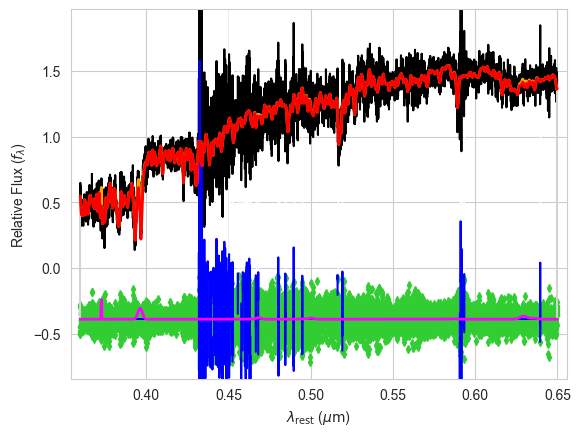

In [201]:
pps[0].plot()

## Save everything

In [202]:
df_out = pd.DataFrame()
df_out['ID_INSPIRE'] = ids
df_out['logAge'] = logAges
df_out['[M/H]'] = metals
df_out['SNR'] = snrs

df_out['mass_frac'] = mass_fracs
df_out['time_75'] = times_75
df_out['time_90'] = times_90
df_out['time_100'] = times_100
df_out['dor_100'] = dors_100
df_out['univ_age'] = univ_ages

df_out['mass_frac_reg'] = mass_fracsr
df_out['time_75_reg'] = times_75r
df_out['time_90_reg'] = times_90r
df_out['time_100_reg'] = times_100r
df_out['dor_100_reg'] = dors_100r

df_out['mass_frac_unr'] = mass_fracsu
df_out['time_75_unr'] = times_75u
df_out['time_90_unr'] = times_90u
df_out['time_100_unr'] = times_100u
df_out['dor_100_unr'] = dors_100u

df_out.head()

,ID_INSPIRE,logAge,[M/H],SNR,mass_frac,time_75,time_90,time_100,dor_100,univ_age,mass_frac_reg,time_75_reg,time_90_reg,time_100_reg,dor_100_reg,mass_frac_unr,time_75_unr,time_90_unr,time_100_unr,dor_100_unr
0,J1438-0127,10.042875,0.139520,22.964796,0.75564,2.81397,3.44070,11.22697,0.365175,12.565039,0.75564,2.81397,3.44070,11.22697,0.579939,0.92271,1.65072,2.51261,9.24697,0.729893
1,J1412-0020,10.047341,0.216643,12.835432,0.82150,1.75956,4.33012,12.16199,0.397816,12.565039,0.82150,1.64948,4.33012,11.94056,0.624775,0.95491,1.75956,2.43080,12.16199,0.657050
2,J0224-3143,10.055513,0.221082,19.544622,0.93231,1.85098,2.60343,12.33184,0.425569,12.565039,0.93231,1.29325,2.58268,12.33184,0.679164,0.93409,1.85098,2.60343,12.33058,0.640959
3,J2356-3332,9.935665,0.171035,12.710780,0.50836,5.36893,6.76504,12.35559,0.224623,12.565039,0.50836,5.36893,6.76504,12.35559,0.439386,0.70537,3.15190,4.45611,12.35446,0.526921
4,J0918+0122,10.005893,0.212721,17.286647,0.67260,3.39501,4.39906,12.42324,0.295623,12.565039,0.68964,3.39501,4.13148,12.42324,0.516067,0.67260,3.32319,4.39906,12.40539,0.511921


In [203]:
df_out.to_csv('refitting_results/output.csv', index=False)

In [204]:
print(df_out)
df2 = pd.read_csv('../data/INSPIRE_stelpop.csv')
# df2=df2[df2['ID_INSPIRE'].isin(gal_list)]

print("\n\n\n")

print(df2[['ID_INSPIRE','zspec_XSH', 'ageUni_at_z', 'age_unr', 'age_rmax',
       'metal_unr', 'metal_rmax', 'metal_stdev', 'tuni',
       't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR']].head())

"""print(df2[['ID_INSPIRE','zspec_XSH', 'ageUni_at_z','Vdisp_XSH', 'err_Vdisp_XSH']].head())
print(df2[['AlphaFe', 'err_alphafe', 'age_unr', 'age_rmax', 'age_stdev',]].head())
print(df2[['metal_unr', 'metal_rmax', 'metal_stdev', 'tuni', 'Mtbb3', 'stdev_Mt3',]].head())
print(df2[['t_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR']].head())
"""

    ID_INSPIRE     logAge     [M/H]        SNR  mass_frac   time_75   time_90  \
0   J1438-0127  10.042875  0.139520  22.964796    0.75564   2.81397   3.44070   
1   J1412-0020  10.047341  0.216643  12.835432    0.82150   1.75956   4.33012   
2   J0224-3143  10.055513  0.221082  19.544622    0.93231   1.85098   2.60343   
3   J2356-3332   9.935665  0.171035  12.710780    0.50836   5.36893   6.76504   
4   J0918+0122  10.005893  0.212721  17.286647    0.67260   3.39501   4.39906   
5   J1411+0233   9.964387  0.126034  29.338998    0.65969   4.13800   6.07021   
6   J1420-0035  10.040776  0.215929  15.281143    0.81292   2.56506   3.86486   
7   J1114+0039   9.988769  0.188174  21.365602    0.63786   3.72996   4.84223   
8   J0316-2953  10.008040  0.026743  12.313803    0.77666   2.43716   5.03108   
9   J1527-0012   9.992627  0.114020  12.873862    0.58627   4.13128   6.01158   
10  J1527-0023  10.003565  0.051266  12.223169    0.82942   2.32697   7.02605   
11  J0321-3213  10.005535  0

"print(df2[['ID_INSPIRE','zspec_XSH', 'ageUni_at_z','Vdisp_XSH', 'err_Vdisp_XSH']].head())\nprint(df2[['AlphaFe', 'err_alphafe', 'age_unr', 'age_rmax', 'age_stdev',]].head())\nprint(df2[['metal_unr', 'metal_rmax', 'metal_stdev', 'tuni', 'Mtbb3', 'stdev_Mt3',]].head())\nprint(df2[['t_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR']].head())\n"

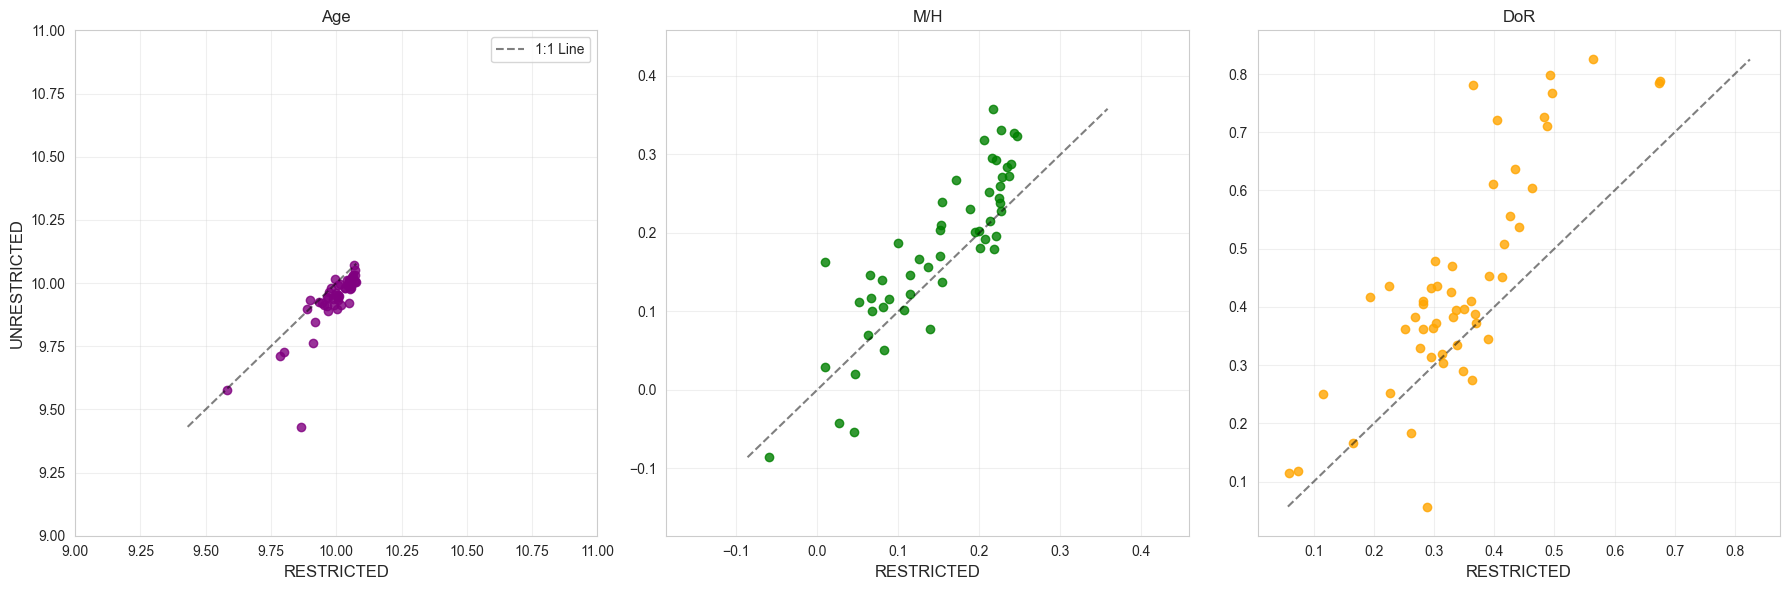

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

merged_df = pd.merge(df_out, df2, on='ID_INSPIRE', how='inner')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

merged_df['age_avg'] = (merged_df['age_unr'] + merged_df['age_rmax']) / 2
merged_df['age_avg'] = np.log10(merged_df['age_avg'])+9

axes[0].scatter(merged_df['logAge'], merged_df['age_avg'], alpha=0.8, color='purple')
axes[0].set_ylabel('UNRESTRICTED', fontsize=12)
axes[0].set_xlabel('RESTRICTED', fontsize=12)
axes[0].set_title('Age')

# Add a 1:1 reference line
min_val = min(merged_df['logAge'].min(), merged_df['age_avg'].min())
max_val = max(merged_df['logAge'].max(), merged_df['age_avg'].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 Line')

axes[0].grid(alpha=0.3)
axes[0].legend()
axes[0].set_xlim(9, 11)
axes[0].set_ylim(9, 11)


merged_df['metal_avg'] = (merged_df['metal_unr'] + merged_df['metal_rmax']) / 2
axes[1].scatter(merged_df['[M/H]'], merged_df['metal_avg'], alpha=0.8, color='green')

# Add a 1:1 reference line
min_val = min(merged_df['[M/H]'].min(), merged_df['metal_avg'].min())
max_val = max(merged_df['[M/H]'].max(), merged_df['metal_avg'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 Line')

axes[1].grid(alpha=0.3)
metal_min = min(merged_df['[M/H]'].min(), merged_df['metal_avg'].min()) - 0.1
metal_max = max(merged_df['[M/H]'].max(), merged_df['metal_avg'].max()) + 0.1
axes[1].set_xlim(metal_min, metal_max)
axes[1].set_ylim(metal_min, metal_max)
axes[1].set_xlabel('RESTRICTED', fontsize=12)
axes[1].set_title('M/H')




axes[2].scatter(merged_df['dor_100'], merged_df['DoR'], alpha=0.8, color='orange')
axes[2].set_title('Comparison of Degrees of Relicness', fontsize=14)
# Add a 1:1 reference line
min_val = min(merged_df['dor_100'].min(), merged_df['DoR'].min())
max_val = max(merged_df['dor_100'].max(), merged_df['DoR'].max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 Line')
axes[2].set_xlabel('RESTRICTED', fontsize=12)
axes[2].set_title('DoR')

axes[2].grid(alpha=0.3)
dor_min = min(merged_df['dor_100'].min(), merged_df['DoR'].min()) - 0.05
dor_max = max(merged_df['dor_100'].max(), merged_df['DoR'].max()) + 0.05
axes[2].set_xlim(dor_min, dor_max)
axes[2].set_ylim(dor_min, dor_max)

plt.tight_layout()
plt.savefig('comparison_plots.png', dpi=300)
plt.show()


## Compute everything for alpha/Fe±0.1

In [206]:
tie_balmer = True
limit_doublets = True

c = 299792.458  # speed of light in km/s

regul_err = 0.1 # Large regularization error

vel = 0   # eq.(8) of Cappellari (2017)

moments = [4, 2, 2]

gas_reddening = 0 if tie_balmer else None

logAges = []
metals = []
snrs = []

In [207]:
"""# Same logic as before but no bootstrapping
for index, row in df_out.iterrows():

    plate = row['plate']
    mjd = row['mjd']
    fiberid = row['fiberid']
    txt_name = '/spec-' + f'{plate:04}' + '-' + f'{mjd:05}' + '-' + f'{fiberid:04}' + '.fits'

    hdu = fits.open('/Users/johnmills/Summer project/alpha_calculator/fits_shortlist' + txt_name, ignore_missing_simple=True)
    t = hdu['COADD'].data

    galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
    ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
    wave0 = np.exp(ln_lam_gal)

    redshift = row['z']
    sigma = row['velDisp_ppxf']
    alpha_orig = row['alpha']

    wave = wave0/(1 + redshift)  # Compute wave in the galaxy rest frame
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]

    # # alpha + 0.1
    if alpha_orig < 0.4:
        alpha = alpha_orig + 0.1

        if alpha_orig == 0 and row['alpha_flag'] == -1:
            alpha = 0.4

        alpha = str(int(alpha*10))

        snr = DER_SNR(galaxy)
        snrs.append(snr)

        wave *= np.median(util.vac_to_air(wave)/wave)

        noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

        d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
        velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
        FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

        # filename = f'/Users/johnmills/Summer project/MILES_SSP/alpha{alpha}.npz'
        sps = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator([redshift]).zage_Gyr], metal_range=[-2, 0.5])

        reg_dim = sps.templates.shape[1:]
        stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

        lam_range_gal = np.array([np.min(wave), np.max(wave)])

        gas_templates, gas_names, line_wave = util.emission_lines(
            sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
            limit_doublets=limit_doublets)
        
        templates = np.column_stack([stars_templates, gas_templates])

        start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

        n_temps = stars_templates.shape[1]
        n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
        n_balmer = len(gas_names) - n_forbidden

        component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
        gas_component = np.array(component) > 0  # gas_component=True for gas templates

        start = [start, start, start]

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                    degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                    regul=1/regul_err, reg_dim=reg_dim, component=component,
                    gas_component=gas_component, gas_names=gas_names,
                    gas_reddening=gas_reddening, clean=True, quiet=True)
        
        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

        mean_age = sps.mean_age_metal(weights, quiet=True)

        hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
        hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
        hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
        hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
        bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
        lam = fits.ImageHDU(data=wave,name='wavelength')
        orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
        gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

        #Store the results in a way that is suitable for Peppe's SFH plotting
        name = row['sexa_id'] #This is just the ID
        z_orig = redshift # This should be the original redshift of each galaxy
        # Write outputs in fits files
        hdr = fits.Header()
        hdr['HIERARCH SDSS_ID'] = row['objid']
        hdr['HIERARCH NAME'] = name
        hdr['HIERARCH z'] = z_orig
        hdr['HIERARCH mean_age_unr'] = mean_age[0]
        hdr['HIERARCH mean_metal_unr'] = mean_age[1]
        hdr['HIERARCH Mg/Fe'] = row['alpha']
        hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
        hdr['HIERARCH SNR'] = snr
        primary_hdu = fits.PrimaryHDU(header=hdr)
        hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
        hdulis = fits.HDUList(hdulist)
        savepath = 'refitting_results/'
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        hdulis.writeto(savepath+name+'_ppxfout_plus.fits',overwrite=True)

    # alpha - 0.1
    if alpha_orig > 0:
        alpha = alpha_orig - 0.1

        if alpha_orig == 0.4 and row['alpha_flag'] == 1:
            alpha = 0.

        alpha = str(int(alpha*10))

        snr = DER_SNR(galaxy)
        snrs.append(snr)

        wave *= np.median(util.vac_to_air(wave)/wave)

        noise = np.full_like(galaxy, 0.0163)

        d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)
        velscale = c*d_ln_lam
        FWHM_gal = 2.76/(1+redshift)

        filename = f'../data/MILES_SSP_SAFE/alpha{alpha}.npz'

        sps = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator([redshift]).zage_Gyr], metal_range=[-2, 0.5])

        reg_dim = sps.templates.shape[1:]
        stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

        lam_range_gal = np.array([np.min(wave), np.max(wave)])

        gas_templates, gas_names, line_wave = util.emission_lines(
            sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
            limit_doublets=limit_doublets)
        
        templates = np.column_stack([stars_templates, gas_templates])

        start = [vel, sigma]

        n_temps = stars_templates.shape[1]
        n_forbidden = np.sum(["[" in a for a in gas_names])
        n_balmer = len(gas_names) - n_forbidden

        component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
        gas_component = np.array(component) > 0

        start = [start, start, start]

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)

        noise = noise*np.sqrt(pp.chi2)

        pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                    degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                    regul=1/regul_err, reg_dim=reg_dim, component=component,
                    gas_component=gas_component, gas_names=gas_names,
                    gas_reddening=gas_reddening, clean=True, quiet=True)
        
        weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

        mean_age = sps.mean_age_metal(weights, quiet=True)

        hdu_wei = fits.ImageHDU(data=weights,name='pp_weights') # save the grid before reshaping the weights
        hdu_regdim = fits.ImageHDU(data=reg_dim,name='reg_dim')
        hdu_age = fits.ImageHDU(data=sps.age_grid,name='age_grid')
        hdu_metal = fits.ImageHDU(data=sps.metal_grid,name='metal_grid')
        bestfit = fits.ImageHDU(data=pp.bestfit,name='bestfit_spectrum')
        lam = fits.ImageHDU(data=wave,name='wavelength')
        orig = fits.ImageHDU(data=galaxy,name='original_spectrum')
        gas = fits.ImageHDU(data=pp.gas_bestfit,name='gas_bestfit')

        #Store the results in a way that is suitable for Peppe's SFH plotting
        name = row['sexa_id'] #This is just the ID
        z_orig = redshift # This should be the original redshift of each galaxy
        # Write outputs in fits files
        hdr = fits.Header()
        hdr['HIERARCH SDSS_ID'] = row['objid']
        hdr['HIERARCH NAME'] = name
        hdr['HIERARCH z'] = z_orig
        hdr['HIERARCH mean_age_unr'] = mean_age[0]
        hdr['HIERARCH mean_metal_unr'] = mean_age[1]
        hdr['HIERARCH Mg/Fe'] = row['alpha']
        hdr['HIERARCH velDisp'] = row['velDisp_ppxf']
        hdr['HIERARCH SNR'] = snr
        primary_hdu = fits.PrimaryHDU(header=hdr)
        hdulist = [primary_hdu, hdu_wei, hdu_regdim, hdu_age, hdu_metal, bestfit, lam, orig, gas]
        hdulis = fits.HDUList(hdulist)
        savepath = './ppxf_fits_test2/'
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        hdulis.writeto(savepath+name+'_ppxfout_minus.fits',overwrite=True)

    print(f'Galaxy {index} done')
"""
print("SKIPPPPPP")

SKIPPPPPP
